In [1]:
%matplotlib inline
import sys
sys.path.append('../../')
from ef.config.visualizer import Visualizer3d
from ef.config.efconf import EfConf

Dynamics of a single particle in free space is the simplest kind of simulation. It allows to check basic functionality of the program, and, besides, it is a good way to become familiar with how the program works.

In absence of external forces, a body moves in straight line with constant velocity

\begin{align}
& \textbf{r}(t) = \textbf{r}_0 + \textbf{v}_0 t
\\
& \textbf{v}(t) = \textbf{v}_0
\end{align}

To get some sense of scales (see below), suppose the particle is an electron that has just passed an 1 keV accelerating potential difference. Its mass `m` and charge `q` are `q = 4.8e-10 [cgs], m = 9.1e-28 [g]`. Since its energy is nonrelativistic, it's possible to calculate its speed simply as $v = \sqrt{ 2 E / m } = 1.808e+09 ~ [cm/s]$. To cover a `10 [cm]` distance with such speed, it will take the electron `t = 5.530e-09 [s] ~ 6 [ns]`.

In [2]:
from math import *

m = 9.8e-28
q = 4.8e-10
print( "q = {:.3e} [cgs]".format( q ) )
print( "m = {:.3e} [g]".format( m ) )

ev_to_cgs = 1.60218e-12
E = 1000 * ev_to_cgs
v = sqrt( 2 * E / m )
z = 10
t = z / v
print( "E = {:.3e} [eV] = {:.3e} [erg]".format( E / ev_to_cgs, E ) )
print( "v = {:.3e} [cm/s]; p = {:.3e} [g * cm/s]".format( v, v * m ) )
print( "z = {:.3e} [cm]".format( z ) )
print( "t = {:.3e} [s]".format( t ) )

q = 4.800e-10 [cgs]
m = 9.800e-28 [g]
E = 1.000e+03 [eV] = 1.602e-09 [erg]
v = 1.808e+09 [cm/s]; p = 1.772e-18 [g * cm/s]
z = 1.000e+01 [cm]
t = 5.530e-09 [s]


To perform a simulation, it's necessary to prepare a config file. It is an `ini`-file with sections describing the simulation parameters, e.g.:

```
[TimeGrid]
total_time = 6e-09
time_save_step = 6e-12
time_step_size = 6e-12

[SpatialMesh]
grid_x_size = 5.0
grid_x_step = 0.5
grid_y_size = 5.0
grid_y_step = 0.5
grid_z_size = 15.0
grid_z_step = 1.5

[ParticleSourceBox.emit_single_particle]
box_x_left = 0.11
box_x_right = 0.1
...
```
If Ef is invoked from the command line, this file is passed as an argument:

```
./ef.out conf.ini
```

Ef Jupyter module can be used to simplify config preparation, but for the first example the config is prepared manually. 

The list of supported config sections can be found in the wiki: https://github.com/epicf/ef/wiki/Supported-Config-File-Sections .

First, it's necessary to set a total time of the simulation and a time step.
Let's use the estimates above as guiding values and set the total time to `6e-9 [s]`.
We use `1000` time steps, so that `time_step_size = 6.0e-12 [s]`. 
Besides, it's necessary to decide at which time steps the state of the whole simulation should be saved to the disk.
To save each step, `time_save_step` is set equal to `time_step_size`: `time_save_step = 6.0e-12`.

In [3]:
single_particle_in_free_space_conf = ""

time_grid_sec = """
[TimeGrid]
total_time = 6e-09
time_save_step = 6e-12
time_step_size = 6e-12
"""

single_particle_in_free_space_conf = single_particle_in_free_space_conf + time_grid_sec

print( single_particle_in_free_space_conf )


[TimeGrid]
total_time = 6e-09
time_save_step = 6e-12
time_step_size = 6e-12



Next we need to define size of a computational volume.
Domain size is set to 15 [cm] along the z-axis and 5 [cm] along the x- and y-axes. 
The parameters for PIC-mesh are also defined in this section.
Since we are going to use noninteracting particle model instead of PIC, they are not used and can be set arbitrary. 

In [4]:
spat_mesh_sec = """
[SpatialMesh]
grid_x_size = 5.0
grid_x_step = 0.5
grid_y_size = 5.0
grid_y_step = 0.5
grid_z_size = 15.0
grid_z_step = 1.5
"""

single_particle_in_free_space_conf = single_particle_in_free_space_conf + spat_mesh_sec

print( single_particle_in_free_space_conf )


[TimeGrid]
total_time = 6e-09
time_save_step = 6e-12
time_step_size = 6e-12

[SpatialMesh]
grid_x_size = 5.0
grid_x_step = 0.5
grid_y_size = 5.0
grid_y_step = 0.5
grid_z_size = 15.0
grid_z_step = 1.5



Next, a particle source. 
We need a single particle at startup ( `initial_number_of_particles = 1` ), approximately 1 [mm] away from
coordinate axis origin at the bottom-left-near corner of the domain (`shape = Box( origin = (0.1, ...` below and `box_x_left = 0.10 ...` in the ini-version).
Charge and mass are set to those of the electron.
Momentum corresponding to 1 keV energy is `1.772e-18 [g * cm / s]`.
Such value is set for momentum along the z-axis. 
Momenta along the x- and y-axes could be set to zero; instead they are chosen 3 times smaller than the z-axis momentum
(domain size along the x and y is 3 times smaller than along the z). 
To prevent any variation in momentum, the `temperature` is set to 0.
Notice that the source is given a descriptive name: `emit_single_particle` in this case.

In [5]:
emit_single_particle_sec = """
[ParticleSourceBox.emit_single_particle]
box_x_left = 0.11
box_x_right = 0.1
box_y_bottom = 0.1
box_y_top = 0.11
box_z_near = 0.1
box_z_far = 0.11
initial_number_of_particles = 1
particles_to_generate_each_step = 0
mean_momentum_x = 6e-19
mean_momentum_y = 6e-19
mean_momentum_z = 1.77e-18
temperature = 0.0
charge = 4.8e-10
mass = 9.8e-28
"""

single_particle_in_free_space_conf = single_particle_in_free_space_conf + emit_single_particle_sec

print( single_particle_in_free_space_conf )


[TimeGrid]
total_time = 6e-09
time_save_step = 6e-12
time_step_size = 6e-12

[SpatialMesh]
grid_x_size = 5.0
grid_x_step = 0.5
grid_y_size = 5.0
grid_y_step = 0.5
grid_z_size = 15.0
grid_z_step = 1.5

[ParticleSourceBox.emit_single_particle]
box_x_left = 0.11
box_x_right = 0.1
box_y_bottom = 0.1
box_y_top = 0.11
box_z_near = 0.1
box_z_far = 0.11
initial_number_of_particles = 1
particles_to_generate_each_step = 0
mean_momentum_x = 6e-19
mean_momentum_y = 6e-19
mean_momentum_z = 1.77e-18
temperature = 0.0
charge = 4.8e-10
mass = 9.8e-28



Next section is boundary conditions. 
In a free space, potentials on each boundary should be equal. 
It is possible to simply set them to zero.

In [6]:
boundary_sec = """
[BoundaryConditions]
boundary_phi_right = 0.0
boundary_phi_left = 0.0
boundary_phi_bottom = 0.0
boundary_phi_top = 0.0
boundary_phi_near = 0.0
boundary_phi_far = 0.0
"""

single_particle_in_free_space_conf = single_particle_in_free_space_conf + boundary_sec

print( single_particle_in_free_space_conf )


[TimeGrid]
total_time = 6e-09
time_save_step = 6e-12
time_step_size = 6e-12

[SpatialMesh]
grid_x_size = 5.0
grid_x_step = 0.5
grid_y_size = 5.0
grid_y_step = 0.5
grid_z_size = 15.0
grid_z_step = 1.5

[ParticleSourceBox.emit_single_particle]
box_x_left = 0.11
box_x_right = 0.1
box_y_bottom = 0.1
box_y_top = 0.11
box_z_near = 0.1
box_z_far = 0.11
initial_number_of_particles = 1
particles_to_generate_each_step = 0
mean_momentum_x = 6e-19
mean_momentum_y = 6e-19
mean_momentum_z = 1.77e-18
temperature = 0.0
charge = 4.8e-10
mass = 9.8e-28

[BoundaryConditions]
boundary_phi_right = 0.0
boundary_phi_left = 0.0
boundary_phi_bottom = 0.0
boundary_phi_top = 0.0
boundary_phi_near = 0.0
boundary_phi_far = 0.0



Particle interaction model allows to choose between noninteracting particles, particle interacting with binary forces and PIC method. Since there is only one particle, there is no need to use PIC, and noninteracting mode is enough. Moreover, PIC will lead to wrong results (because particle creates electric field that acts back on the particle). 

In [7]:
particle_interaction_model_sec = """
[ParticleInteractionModel]
particle_interaction_model = noninteracting
"""

single_particle_in_free_space_conf = single_particle_in_free_space_conf + particle_interaction_model_sec

print( single_particle_in_free_space_conf )


[TimeGrid]
total_time = 6e-09
time_save_step = 6e-12
time_step_size = 6e-12

[SpatialMesh]
grid_x_size = 5.0
grid_x_step = 0.5
grid_y_size = 5.0
grid_y_step = 0.5
grid_z_size = 15.0
grid_z_step = 1.5

[ParticleSourceBox.emit_single_particle]
box_x_left = 0.11
box_x_right = 0.1
box_y_bottom = 0.1
box_y_top = 0.11
box_z_near = 0.1
box_z_far = 0.11
initial_number_of_particles = 1
particles_to_generate_each_step = 0
mean_momentum_x = 6e-19
mean_momentum_y = 6e-19
mean_momentum_z = 1.77e-18
temperature = 0.0
charge = 4.8e-10
mass = 9.8e-28

[BoundaryConditions]
boundary_phi_right = 0.0
boundary_phi_left = 0.0
boundary_phi_bottom = 0.0
boundary_phi_top = 0.0
boundary_phi_near = 0.0
boundary_phi_far = 0.0

[ParticleInteractionModel]
particle_interaction_model = noninteracting



The last step is to specify pattern for output file names. 
They will be of the form `single_particle_free_space_0001000.h5`, where `0001000` is a time step number.

In [8]:
output_sec = """
[OutputFilename]
output_filename_prefix = single_particle_free_space_
output_filename_suffix = .h5
"""

single_particle_in_free_space_conf = single_particle_in_free_space_conf + output_sec

print( single_particle_in_free_space_conf )


[TimeGrid]
total_time = 6e-09
time_save_step = 6e-12
time_step_size = 6e-12

[SpatialMesh]
grid_x_size = 5.0
grid_x_step = 0.5
grid_y_size = 5.0
grid_y_step = 0.5
grid_z_size = 15.0
grid_z_step = 1.5

[ParticleSourceBox.emit_single_particle]
box_x_left = 0.11
box_x_right = 0.1
box_y_bottom = 0.1
box_y_top = 0.11
box_z_near = 0.1
box_z_far = 0.11
initial_number_of_particles = 1
particles_to_generate_each_step = 0
mean_momentum_x = 6e-19
mean_momentum_y = 6e-19
mean_momentum_z = 1.77e-18
temperature = 0.0
charge = 4.8e-10
mass = 9.8e-28

[BoundaryConditions]
boundary_phi_right = 0.0
boundary_phi_left = 0.0
boundary_phi_bottom = 0.0
boundary_phi_top = 0.0
boundary_phi_near = 0.0
boundary_phi_far = 0.0

[ParticleInteractionModel]
particle_interaction_model = noninteracting

[OutputFilename]
output_filename_prefix = single_particle_free_space_
output_filename_suffix = .h5



To start the simulation, the config should saved into file and provided as an argument to the `ef.out`, e.g.:

```
ef.out ./single_particle_in_free_space_conf.ini
```

EfJupyter module provides a wrapper `EfRunner` to do this.  

In [9]:
from ef.util.runner import EfRunner

ef_jupyter_config_representation = EfConf.from_string(single_particle_in_free_space_conf)

runner = EfRunner(conf = ef_jupyter_config_representation, ef_command="python3 ../../main.py")
runner.run()

command: python3 ../../main.py /tmp/tmpbxmwf0ti.ini
b'Config file is:  /tmp/tmpbxmwf0ti.ini'
b'[ TimeGrid ]'
b'total_time = 6e-09'
b'time_save_step = 6e-12'
b'time_step_size = 6e-12'
b'[ SpatialMesh ]'
b'grid_x_size = 5.0'
b'grid_x_step = 0.5'
b'grid_y_size = 5.0'
b'grid_y_step = 0.5'
b'grid_z_size = 15.0'
b'grid_z_step = 1.5'
b'[ ParticleSourceBox.emit_single_particle ]'
b'box_x_left = 0.11'
b'box_x_right = 0.1'
b'box_y_bottom = 0.1'
b'box_y_top = 0.11'
b'box_z_near = 0.1'
b'box_z_far = 0.11'
b'initial_number_of_particles = 1'
b'particles_to_generate_each_step = 0'
b'mean_momentum_x = 6e-19'
b'mean_momentum_y = 6e-19'
b'mean_momentum_z = 1.77e-18'
b'temperature = 0.0'
b'charge = 4.8e-10'
b'mass = 9.8e-28'
b'[ OutputFilename ]'
b'output_filename_prefix = single_particle_free_space_'
b'output_filename_suffix = .h5'
b'[ BoundaryConditions ]'
b'boundary_phi_right = 0.0'
b'boundary_phi_left = 0.0'
b'boundary_phi_bottom = 0.0'
b'boundary_phi_top = 0.0'
b'boundary_phi_near = 0.0'
b'boundary_

b'Writing step 47 to file single_particle_free_space_0000047.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 47 to 48 of 1000'
b'Writing step 48 to file single_particle_free_space_0000048.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 48 to 49 of 1000'
b'Writing step 49 to file single_particle_free_space_0000049.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 49 to 50 of 1000'
b'Writing step 50 to file single_particle_free_space_0000050.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 50 to 51 of 1000'
b'Writing step 51 to file single_particle_free_space_0000051.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 51 to 52 of 1000'
b'Writing step 52 to file single_particle_free_space_0000052.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 52 to 53 of 1000'
b'Writing step 53 to f

b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 100 to 101 of 1000'
b'Writing step 101 to file single_particle_free_space_0000101.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 101 to 102 of 1000'
b'Writing step 102 to file single_particle_free_space_0000102.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 102 to 103 of 1000'
b'Writing step 103 to file single_particle_free_space_0000103.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 103 to 104 of 1000'
b'Writing step 104 to file single_particle_free_space_0000104.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 104 to 105 of 1000'
b'Writing step 105 to file single_particle_free_space_0000105.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 105 to 106 of 1000'
b'Writing step 106 to file single_particle_free_space_0000106.h5'
b'So

b'Time step from 152 to 153 of 1000'
b'Writing step 153 to file single_particle_free_space_0000153.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 153 to 154 of 1000'
b'Writing step 154 to file single_particle_free_space_0000154.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 154 to 155 of 1000'
b'Writing step 155 to file single_particle_free_space_0000155.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 155 to 156 of 1000'
b'Writing step 156 to file single_particle_free_space_0000156.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 156 to 157 of 1000'
b'Writing step 157 to file single_particle_free_space_0000157.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 157 to 158 of 1000'
b'Writing step 158 to file single_particle_free_space_0000158.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Ti

b'Writing step 205 to file single_particle_free_space_0000205.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 205 to 206 of 1000'
b'Writing step 206 to file single_particle_free_space_0000206.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 206 to 207 of 1000'
b'Writing step 207 to file single_particle_free_space_0000207.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 207 to 208 of 1000'
b'Writing step 208 to file single_particle_free_space_0000208.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 208 to 209 of 1000'
b'Writing step 209 to file single_particle_free_space_0000209.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 209 to 210 of 1000'
b'Writing step 210 to file single_particle_free_space_0000210.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 210 to 211 of 1000'
b'Wr

b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 257 to 258 of 1000'
b'Writing step 258 to file single_particle_free_space_0000258.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 258 to 259 of 1000'
b'Writing step 259 to file single_particle_free_space_0000259.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 259 to 260 of 1000'
b'Writing step 260 to file single_particle_free_space_0000260.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 260 to 261 of 1000'
b'Writing step 261 to file single_particle_free_space_0000261.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 261 to 262 of 1000'
b'Writing step 262 to file single_particle_free_space_0000262.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 262 to 263 of 1000'
b'Writing step 263 to file single_particle_free_space_0000263.h5'
b'So

b'Time step from 309 to 310 of 1000'
b'Writing step 310 to file single_particle_free_space_0000310.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 310 to 311 of 1000'
b'Writing step 311 to file single_particle_free_space_0000311.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 311 to 312 of 1000'
b'Writing step 312 to file single_particle_free_space_0000312.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 312 to 313 of 1000'
b'Writing step 313 to file single_particle_free_space_0000313.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 313 to 314 of 1000'
b'Writing step 314 to file single_particle_free_space_0000314.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 314 to 315 of 1000'
b'Writing step 315 to file single_particle_free_space_0000315.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Ti

b'Writing step 362 to file single_particle_free_space_0000362.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 362 to 363 of 1000'
b'Writing step 363 to file single_particle_free_space_0000363.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 363 to 364 of 1000'
b'Writing step 364 to file single_particle_free_space_0000364.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 364 to 365 of 1000'
b'Writing step 365 to file single_particle_free_space_0000365.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 365 to 366 of 1000'
b'Writing step 366 to file single_particle_free_space_0000366.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 366 to 367 of 1000'
b'Writing step 367 to file single_particle_free_space_0000367.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 367 to 368 of 1000'
b'Wr

b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 414 to 415 of 1000'
b'Writing step 415 to file single_particle_free_space_0000415.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 415 to 416 of 1000'
b'Writing step 416 to file single_particle_free_space_0000416.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 416 to 417 of 1000'
b'Writing step 417 to file single_particle_free_space_0000417.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 417 to 418 of 1000'
b'Writing step 418 to file single_particle_free_space_0000418.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 418 to 419 of 1000'
b'Writing step 419 to file single_particle_free_space_0000419.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 419 to 420 of 1000'
b'Writing step 420 to file single_particle_free_space_0000420.h5'
b'So

b'Time step from 466 to 467 of 1000'
b'Writing step 467 to file single_particle_free_space_0000467.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 467 to 468 of 1000'
b'Writing step 468 to file single_particle_free_space_0000468.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 468 to 469 of 1000'
b'Writing step 469 to file single_particle_free_space_0000469.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 469 to 470 of 1000'
b'Writing step 470 to file single_particle_free_space_0000470.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 470 to 471 of 1000'
b'Writing step 471 to file single_particle_free_space_0000471.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 471 to 472 of 1000'
b'Writing step 472 to file single_particle_free_space_0000472.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Ti

b'Writing step 519 to file single_particle_free_space_0000519.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 519 to 520 of 1000'
b'Writing step 520 to file single_particle_free_space_0000520.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 520 to 521 of 1000'
b'Writing step 521 to file single_particle_free_space_0000521.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 521 to 522 of 1000'
b'Writing step 522 to file single_particle_free_space_0000522.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 522 to 523 of 1000'
b'Writing step 523 to file single_particle_free_space_0000523.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 523 to 524 of 1000'
b'Writing step 524 to file single_particle_free_space_0000524.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 524 to 525 of 1000'
b'Wr

b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 571 to 572 of 1000'
b'Writing step 572 to file single_particle_free_space_0000572.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 572 to 573 of 1000'
b'Writing step 573 to file single_particle_free_space_0000573.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 573 to 574 of 1000'
b'Writing step 574 to file single_particle_free_space_0000574.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 574 to 575 of 1000'
b'Writing step 575 to file single_particle_free_space_0000575.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 575 to 576 of 1000'
b'Writing step 576 to file single_particle_free_space_0000576.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 576 to 577 of 1000'
b'Writing step 577 to file single_particle_free_space_0000577.h5'
b'So

b'Time step from 623 to 624 of 1000'
b'Writing step 624 to file single_particle_free_space_0000624.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 624 to 625 of 1000'
b'Writing step 625 to file single_particle_free_space_0000625.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 625 to 626 of 1000'
b'Writing step 626 to file single_particle_free_space_0000626.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 626 to 627 of 1000'
b'Writing step 627 to file single_particle_free_space_0000627.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 627 to 628 of 1000'
b'Writing step 628 to file single_particle_free_space_0000628.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 628 to 629 of 1000'
b'Writing step 629 to file single_particle_free_space_0000629.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Ti

b'Writing step 676 to file single_particle_free_space_0000676.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 676 to 677 of 1000'
b'Writing step 677 to file single_particle_free_space_0000677.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 677 to 678 of 1000'
b'Writing step 678 to file single_particle_free_space_0000678.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 678 to 679 of 1000'
b'Writing step 679 to file single_particle_free_space_0000679.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 679 to 680 of 1000'
b'Writing step 680 to file single_particle_free_space_0000680.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 680 to 681 of 1000'
b'Writing step 681 to file single_particle_free_space_0000681.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 681 to 682 of 1000'
b'Wr

b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 728 to 729 of 1000'
b'Writing step 729 to file single_particle_free_space_0000729.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 729 to 730 of 1000'
b'Writing step 730 to file single_particle_free_space_0000730.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 730 to 731 of 1000'
b'Writing step 731 to file single_particle_free_space_0000731.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 731 to 732 of 1000'
b'Writing step 732 to file single_particle_free_space_0000732.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 732 to 733 of 1000'
b'Writing step 733 to file single_particle_free_space_0000733.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 733 to 734 of 1000'
b'Writing step 734 to file single_particle_free_space_0000734.h5'
b'So

b'Time step from 780 to 781 of 1000'
b'Writing step 781 to file single_particle_free_space_0000781.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 781 to 782 of 1000'
b'Writing step 782 to file single_particle_free_space_0000782.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 782 to 783 of 1000'
b'Writing step 783 to file single_particle_free_space_0000783.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 783 to 784 of 1000'
b'Writing step 784 to file single_particle_free_space_0000784.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 784 to 785 of 1000'
b'Writing step 785 to file single_particle_free_space_0000785.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 785 to 786 of 1000'
b'Writing step 786 to file single_particle_free_space_0000786.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Ti

b'Writing step 833 to file single_particle_free_space_0000833.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 833 to 834 of 1000'
b'Writing step 834 to file single_particle_free_space_0000834.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 834 to 835 of 1000'
b'Writing step 835 to file single_particle_free_space_0000835.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 835 to 836 of 1000'
b'Writing step 836 to file single_particle_free_space_0000836.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 836 to 837 of 1000'
b'Writing step 837 to file single_particle_free_space_0000837.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 837 to 838 of 1000'
b'Writing step 838 to file single_particle_free_space_0000838.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 838 to 839 of 1000'
b'Wr

b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 885 to 886 of 1000'
b'Writing step 886 to file single_particle_free_space_0000886.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 886 to 887 of 1000'
b'Writing step 887 to file single_particle_free_space_0000887.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 887 to 888 of 1000'
b'Writing step 888 to file single_particle_free_space_0000888.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 888 to 889 of 1000'
b'Writing step 889 to file single_particle_free_space_0000889.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 889 to 890 of 1000'
b'Writing step 890 to file single_particle_free_space_0000890.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 890 to 891 of 1000'
b'Writing step 891 to file single_particle_free_space_0000891.h5'
b'So

b'Time step from 937 to 938 of 1000'
b'Writing step 938 to file single_particle_free_space_0000938.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 938 to 939 of 1000'
b'Writing step 939 to file single_particle_free_space_0000939.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 939 to 940 of 1000'
b'Writing step 940 to file single_particle_free_space_0000940.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 940 to 941 of 1000'
b'Writing step 941 to file single_particle_free_space_0000941.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 941 to 942 of 1000'
b'Writing step 942 to file single_particle_free_space_0000942.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Time step from 942 to 943 of 1000'
b'Writing step 943 to file single_particle_free_space_0000943.h5'
b'Source name = emit_single_particle, number of particles = 1'
b'Ti

After the simulation finishes, a bunch of `*.h5` files emerge in the directory.

In [10]:
!ls

2d.png
3d.png
estimates.py
kin_en.png
plot.py
run_example.sh
single_particle_free_space_0000000.h5
single_particle_free_space_0000001.h5
single_particle_free_space_0000002.h5
single_particle_free_space_0000003.h5
single_particle_free_space_0000004.h5
single_particle_free_space_0000005.h5
single_particle_free_space_0000006.h5
single_particle_free_space_0000007.h5
single_particle_free_space_0000008.h5
single_particle_free_space_0000009.h5
single_particle_free_space_0000010.h5
single_particle_free_space_0000011.h5
single_particle_free_space_0000012.h5
single_particle_free_space_0000013.h5
single_particle_free_space_0000014.h5
single_particle_free_space_0000015.h5
single_particle_free_space_0000016.h5
single_particle_free_space_0000017.h5
single_particle_free_space_0000018.h5
single_particle_free_space_0000019.h5
single_particle_free_space_0000020.h5
single_particle_free_space_0000021.h5
single_particle_free_space_0000022.h5
single_particle_free_space_0000023.h5
single_particle_free_space_

To open these files and glance over the results, an [Hdfview](https://support.hdfgroup.org/products/java/hdfview/) is a convenient tool.
In this simulation, two places are of interest: `current time` and particle position
and momentum at this time moment:

<p align="center">
<img src="https://github.com/epicf/ef/blob/dev/doc/figs/single_particle_in_free_space/hdfview_results.png?raw=true" alt="hdfview screenshot" width="600"/>
</p>

Each created `h5`-file corresponds to a different time step. 
If we were able to extract time, position and momentum of the particle from each file, we could have obtained numerical trajectory, which could be compared to the analytical one. 

Data extraction and plotting are accomplished by the accompanying [`plot.py`](https://github.com/epicf/ef/blob/master/examples/single_particle_in_free_space/plot.py) python script (see below). Its constituent parts are described further. The script produces a 3d plot and side views of the numerical and analytical trajectories. Besides, kinetic energies are compared.

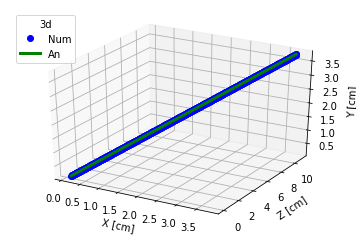

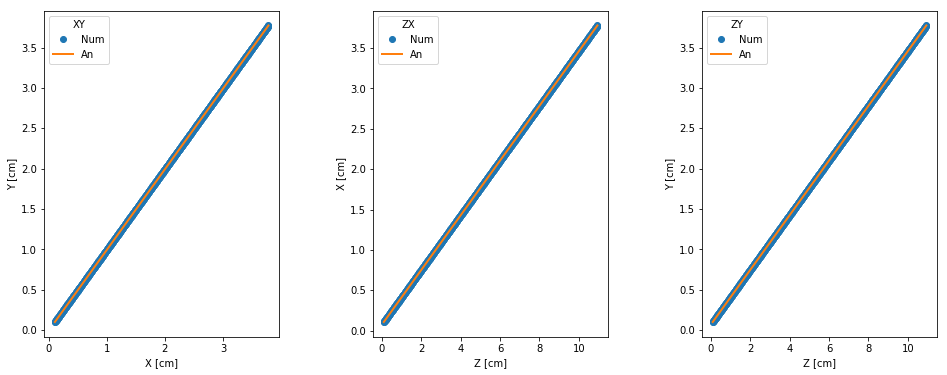

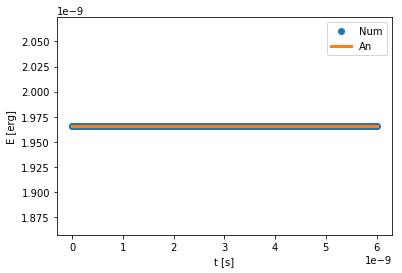

In [11]:
import os, glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

def main():
    num = extract_num_trajectory_from_out_files()
    an = eval_an_trajectory_at_num_time_points( num )
    plot_trajectories( num , an )

def extract_num_trajectory_from_out_files():
    out_files = find_necessary_out_files()    

    num_trajectory = []
    for f in out_files:
        num_trajectory.append( extract_time_pos_mom( f ) )    

    num_trajectory = remove_empty_and_sort_by_time( num_trajectory )
    num_trajectory = np.array( num_trajectory, 
                               dtype=[('t','float'),
                                      ('x','float'), ('y','float'), ('z','float'),
                                      ('px','float'), ('py','float'), ('pz','float') ] )
    return( num_trajectory )

def remove_empty_and_sort_by_time( num_trajectory ):
    removed_empty = [ x for x in num_trajectory if x ]
    sorted_by_time = sorted( removed_empty, key = lambda x: x[0] )
    return ( sorted_by_time )

def find_necessary_out_files():
    os.chdir("./")
    h5files = []
    for file in glob.glob("single_particle_free_space_[0-9]*.h5"):
        h5files.append( file )
    return h5files

def extract_time_pos_mom( h5file ):
    h5 = h5py.File( h5file, mode="r")
    t = h5["/TimeGrid"].attrs["current_time"]
    t_pos_mom = ()
    if ( len(h5["/ParticleSources/emit_single_particle"]) > 0 ):
        x = h5["/ParticleSources/emit_single_particle/position_x"][0]
        y = h5["/ParticleSources/emit_single_particle/position_y"][0]
        z = h5["/ParticleSources/emit_single_particle/position_z"][0]
        px = h5["/ParticleSources/emit_single_particle/momentum_x"][0]
        py = h5["/ParticleSources/emit_single_particle/momentum_y"][0]
        pz = h5["/ParticleSources/emit_single_particle/momentum_z"][0]
        t_pos_mom = (t, x, y, z, px, py, pz)
    h5.close()
    return( t_pos_mom )

def eval_an_trajectory_at_num_time_points( num_trajectory ):
    global particle_mass
    particle_mass, x0, y0, z0, px0, py0, pz0 =  get_mass_and_initial_pos_and_mom()

    an_trajectory = np.empty_like( num_trajectory )
    for i, t in enumerate( num_trajectory['t'] ):
        x, y, z = coords( particle_mass, t, x0, y0, z0, px0, py0, pz0 )
        px, py, pz = momenta( t, px0, py0, pz0 )
        an_trajectory[i] = ( t, x, y ,z, px, py, pz )

    return( an_trajectory )

def get_mass_and_initial_pos_and_mom():
    initial_out_file = "single_particle_free_space_0000000.h5"
    h5 = h5py.File( initial_out_file, mode="r")
    m = h5["/ParticleSources/emit_single_particle"].attrs["mass"]
    x0 = h5["/ParticleSources/emit_single_particle/position_x"][0]
    y0 = h5["/ParticleSources/emit_single_particle/position_y"][0]
    z0 = h5["/ParticleSources/emit_single_particle/position_z"][0]
    px0 = h5["/ParticleSources/emit_single_particle/momentum_x"][0]
    py0 = h5["/ParticleSources/emit_single_particle/momentum_y"][0]
    pz0 = h5["/ParticleSources/emit_single_particle/momentum_z"][0]
    h5.close()
    return( m, x0, y0, z0, px0, py0, pz0 )

def momenta( t, px0, py0, pz0 ):    
    px = px0
    py = py0
    pz = pz0
    return ( px, py, pz )

def coords( m, t, x0, y0, z0, px0, py0, pz0 ):
    x = x0 + px0 / m * t
    y = y0 + py0 / m * t
    z = z0 + pz0 / m * t
    return ( x, y, z )

def plot_trajectories( num , an ):
    plot_3d( num, an )
    plot_2d( num, an )
    plot_kin_en( num , an )

def plot_3d( num, an ):
    fig = plt.figure()
    ax = fig.gca( projection='3d' )
    ax.plot( num['x'], num['z'], num['y'], 'b.', markersize = 12, label = "Num" )
    ax.plot( an['x'], an['z'], an['y'],  'g-', linewidth = 3, label = "An" )
    ax.set_xlabel('X [cm]') 
    ax.set_ylabel('Z [cm]') 
    ax.set_zlabel('Y [cm]')
    plt.legend( loc = 'upper left', title="3d" )
    #print( 'Saving 3d trajectory plot to "3d.png"' )
    #plt.savefig('3d.png')
    plt.show()

def plot_2d( num, an ):
    plt.figure( figsize=( 16, 6 ) )
    plt.subplots_adjust( left = None, bottom = None,
                         right = None, top = None,
                         wspace = 0.4, hspace = None )
    #XY
    ax = plt.subplot(131)
    plt.plot( num['x'], num['y'],
              linestyle='', marker='o',
              label = "Num" )
    plt.plot( an['x'], an['y'],
              linestyle='-', marker='', lw = 2,
              label = "An" )
    ax.set_xlabel('X [cm]') 
    ax.set_ylabel('Y [cm]') 
    plt.legend( loc = 'upper left', title="XY" )
    #ZX
    ax = plt.subplot(132)
    plt.plot( num['z'], num['x'],
        linestyle='', marker='o',
        label = "Num" )
    plt.plot( an['z'], an['x'],
              linestyle='-', marker='', lw = 2,
              label = "An" )
    ax.set_xlabel('Z [cm]') 
    ax.set_ylabel('X [cm]') 
    plt.legend( loc = 'upper left', title="ZX" )
    #ZY
    ax = plt.subplot(133)
    plt.plot( num['z'], num['y'],
        linestyle='', marker='o',
        label = "Num" )
    plt.plot( an['z'], an['y'],
              linestyle='-', marker='', lw = 2,
              label = "An" )
    ax.set_xlabel('Z [cm]') 
    ax.set_ylabel('Y [cm]') 
    plt.legend( loc = 'upper left', title="ZY" )
    #print( 'Saving 2d trajectory projection plots to "2d.png"' )
    #plt.savefig('2d.png')
    plt.show()
    
def plot_kin_en( num , an ):
    global particle_mass
    E_num = ( num['px']**2 + num['py']**2 + num['pz']**2 ) / ( 2 * particle_mass )
    E_an = ( an['px']**2 + an['py']**2 + an['pz']**2 ) / ( 2 * particle_mass )
    t = num['t']
    plt.figure()
    axes = plt.gca()
    axes.set_xlabel( "t [s]" )
    axes.set_ylabel( "E [erg]" )
    # axes.set_ylim( [min( E_an.min(), E_num.min() ),
    #                 max( E_an.max(), E_num.max() ) ] )
    line, = plt.plot( t, E_num, 'o' )
    line.set_label( "Num" )
    line, = plt.plot( t, E_an, ls = 'solid', lw = 3 )
    line.set_label( "An" )
    plt.legend( loc = 'upper right' )
    #print( 'Saving kinetic energy comparison plot to "kin_en.png"' )
    #plt.savefig('kin_en.png')
    plt.show()


main()

It can be seen, that numerical trajectory (points) coincides with the analytical (line) and that the energy is conserved during the simulation.

### Plotting script

The `main` function of the script does exactly what is described above: extracts numerical trajectory from the output files, evaluates analytical trajectory at the extracted time points and plots both numerical and analytical trajectories on the same axes.

```
def main():
    num = extract_num_trajectory_from_out_files()
    an = eval_an_trajectory_at_num_time_points( num )
    plot_trajectories( num , an )
```

It uses [h5py](http://www.h5py.org/) library to read from h5 files, [numpy](http://www.numpy.org/) to simplify working with arrays and [matplotlib](https://matplotlib.org/) to perform plotting of the trajectory. 

```
import os, glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
```

Let's examine the function to obtain the numerical trajectory:

```
def extract_num_trajectory_from_out_files():
    out_files = find_necessary_out_files()                           # (*1)

    num_trajectory = []
    for f in out_files:
        num_trajectory.append( extract_time_pos_mom( f ) )           # (*2)  

    num_trajectory = remove_empty_and_sort_by_time( num_trajectory ) # (*3)
    num_trajectory = np.array( num_trajectory,                       # (*4)
                               dtype=[('t','float'),
                                      ('x','float'), ('y','float'), ('z','float'),
                                      ('px','float'), ('py','float'),('pz','float')])
    return( num_trajectory )
```

(\*1): To extract data, first we find all `*.h5` files in the current directory.  
(\*2): Then the script iterates over them and extracts a relevant data from each one.  
(\*3): In the end of this process, `num_trajectory` array contains positions and velocities of particle at different
time steps. In is convenient to sort it over time values.  
(\*4): After the previous step the numerical trajectory is in a format of a list of tuples:
`[ (t, x, y, z, px, py, pz), ..... ]` . It is convenient to convert it into one of the `np.array` types to simplify further manipulations with it.  

For analytical trajectory we need the initial position and momentum.
They can be extracted from the first h5-file:

```
def get_mass_and_initial_pos_and_mom():
    initial_out_file = "single_particle_free_space_0000000.h5"
    h5 = h5py.File( initial_out_file, mode="r")
    m = h5["/ParticleSources/emit_single_particle"].attrs["mass"][0]
    x0 = h5["/ParticleSources/emit_single_particle/position_x"][0]
    y0 = h5["/ParticleSources/emit_single_particle/position_y"][0]
    z0 = h5["/ParticleSources/emit_single_particle/position_z"][0]
    px0 = h5["/ParticleSources/emit_single_particle/momentum_x"][0]
    py0 = h5["/ParticleSources/emit_single_particle/momentum_y"][0]
    pz0 = h5["/ParticleSources/emit_single_particle/momentum_z"][0]
    h5.close()
    return( m, x0, y0, z0, px0, py0, pz0 )
```

With this function, the analytical trajectory can be computed at the same 
time points as the numerical one:

```
def eval_an_trajectory_at_num_time_points( num_trajectory ):
    global particle_mass
    particle_mass, x0, y0, z0, px0, py0, pz0 =  get_mass_and_initial_pos_and_mom()
    #
    an_trajectory = np.empty_like( num_trajectory )
    for i, t in enumerate( num_trajectory['t'] ):
        x, y, z = coords( particle_mass, t, x0, y0, z0, px0, py0, pz0 )
        px, py, pz = momenta( t, px0, py0, pz0 )
        an_trajectory[i] = ( t, x, y ,z, px, py, pz )
    #
    return( an_trajectory )
```

Finally, both numerical and analytical trajectories are plotted in 3d and side views. 
Kinetic energies are also compared.

```
def plot_trajectories( num , an ):
    plot_3d( num, an )
    plot_2d( num, an )
    plot_kin_en( num , an )
```